# Mini-project II: How many lines are there

The overall project goal is to determine how many signal peaks there are in a noisy set of data.

### Learning goals:
* Use advanced Monte Carlo sampling to generate posterior probability distributions and analyze the results.
* Compute an evidence ratio and explain what it means.
* Employ Bayesian evidence for model selection in the context of a prototype for an experimental nuclear-physics problem.

# A spectral line problem

See e.g. section 4.2 in Sivia for a similar problem formulation. In short, we have data from a spectroscopy experiment that supposedly shows a number of spectral lines. The ideal spectrum, as a function of a scaled coordinate $x$, can be expressed as

$$ G(x) = \sum_{j=1}^M A_j f(x,x_j),$$

where $A_j$ is the amplitude of the $j$th line, and $x_j$ represents its position. If all the spectral lines were Gaussians of width $W$, for example, then

$$ f(x,x_j) = \frac{1}{\sqrt{2\pi W^2}} \exp \left[ - \frac{(x-x_j)^2}{2 W^2} \right]$$

The measurement also includes a background signal which we take to be constant $B(x) = B$. 
 
We us use the label '$k$' to enumerate the bins $\{x_k\}$. The spectrum according to our model is therefore
 
 $$ F_k \equiv F(x_k) = G(x_k) + B.$$

The experimental data is denoted $\{ D_k\}$. This data also includes measurement errors $\varepsilon$ that are assumed to be independent and identically distributed (IID) normal with the same variance $\sigma_\mathrm{exp}$. The measured data is then related to the ideal spectrum by

$$ D_k \equiv D(x_k) = G(x_k) + B + \varepsilon.$$

The task is to infer how many spectral lines ($M$) are in the experimental data, and their positions ($x_j$) and amplitudes ($A_j$). The magnitude of the background is not known before the analysis.

Using scaled parameters the range of peak positions is $[0,1]$, and the range of amplitudes as well as background is also $[0,1]$.

### Solution strategy:
Our model with $M$ lines has $2M+1$ model parameters that we denote by the vector $\vec{\alpha}$. These are the amplitudes, the positions, and the constant background. We order them as follows:

$$ \vec{\alpha} = (A_0, x_0, A_1, x_1, \ldots, B).$$

The background strength is a *nuisance parameter* in the sense that we're not really interested in its value, we just need to marginalize over it.

### Subtasks:
1. Formulate the problem of how many lines and the model parameters in Bayesian language.
1. Using the expressions from step 1, try to derive the posterior probability 
$$
p(M | \{ D_k \}, I ) \propto 
\frac{M! (4 \pi)^M }{\left[ x_\mathrm{max} - x_\mathrm{min} \right]^M \left[ A_\mathrm{max} - A_\mathrm{min} \right]^M \sqrt{\det(\boldsymbol\nabla \boldsymbol\nabla \chi^2)} } 
\exp \left( - \frac{\chi^2_\mathrm{min}}{2} \right).
$$
1. Generate data using the code snippet below, but plan to change values to explore the dependence of the analysis on the number and relative position of peaks, noise, background, etc. Run the data generator several times to observe the degree of fluctuation.
1. Use an MCMC sampler to perform parameter estimation for a known number of signal peaks. Make appropriate plots and analyze the posterior pdf.
1. Use PyMultinest to both infer parameters and compute the evidence for a model with $M$ peaks. Relevant code is given below. Do the results make sense?

## Import statements

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats, scipy

import seaborn as sns
sns.set() # set default plot styles

%matplotlib inline

## Generate data

### Parameters known before the analysis (explore different values for these)

In [5]:
W = 0.12 # The width of the spectral lines
sigma_exp = 0.4 # Variance of IID experimental errors 

In [6]:
# Fixed prior ranges (Don't change these)
xmin=0; xmax=1;
Amin=0; Amax=1;
Bmax=1.;

### Parameters that should be inferred

In [10]:
M = 2 # Number of lines

A0 = 10**np.random.uniform(low=-.5, high=0, size=M) # Amplitudes of the spectral lines

X0 = np.ones(M)*np.random.uniform(low=.1, high=.9, size=1) # Position of the spectral lines

# special tretament to place the lines close together
for i in np.arange(1,M):
    X0[i] += np.random.normal(loc=0,scale=.3)
    X0[i] = min(0.95,X0[i])
    X0[i] = max(0.05,X0[i])

B = np.random.uniform(0.05, 1.) # A constant background signal

In [11]:
def f(x,x0,w):
    '''Simple Gaussian line shape. Position x0, width w.'''
    return np.exp(- (x-x0)**2 / (2 * w**2)) / np.sqrt(2*np.pi*w**2)

def G(x,amplitudes,positions,width=W):
    '''Ideal spectrum composed of N spectral lines with input amplitudes and positions (arrays of length N), 
    and a single, fixed width.'''
    ideal = np.zeros_like(x)
    for a,x0 in zip(amplitudes,positions):
        ideal += a * f(x,x0,width)
    return ideal

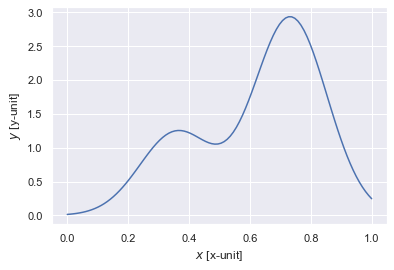

In [12]:
x=np.linspace(xmin,xmax,100)
plt.plot(x,G(x,A0,X0,W))
plt.xlabel('$x$ [x-unit]')
plt.ylabel('$y$ [y-unit]');

Assert: 
1. unknown constant background ($B\le 1$), unknown number of spectral lines with unknown amplitudes and positions.
2. known, natural width (W) of the spectral lines
3. known variance ($\sigma_\mathrm{exp}$) for the IID normal experimental errors
4. known and relevant interval:
   peak positions within [xmin=0, xmax=1] in position space, 
   peak amplitudes within [Amin=0, Amax=1], 

In [13]:
print(f'Natural width of spectral lines:                W = {W}')
print(f'Variance for IID normal exp errors:             s = {sigma_exp}')
print(f'Relevant range in position space:    [xmin, xmax] = [{xmin:.1f}, {xmax:.1f}]')
print(f'Relevant range for peak amplitudes:  [Amin, Amax] = [{Amin:.1f}, {Amax:.1f}]')

Natural width of spectral lines:                W = 0.12
Variance for IID normal exp errors:             s = 0.4
Relevant range in position space:    [xmin, xmax] = [0.0, 1.0]
Relevant range for peak amplitudes:  [Amin, Amax] = [0.0, 1.0]


In [14]:
# Generate experimental data
np.random.seed(42) # For reproducibility
Ndata = 100 # Number of data points
xk = np.linspace(xmin,xmax,Ndata)
sk=np.ones_like(xk)*sigma_exp # We assume that the variance is the same for all k
ek = np.random.normal(loc=0.0, scale=sigma_exp, size=Ndata)
Dk = G(xk,A0,X0,W) + B + ek
# Data saved in a file (but also printed below)
data = [xk,Dk,sk]

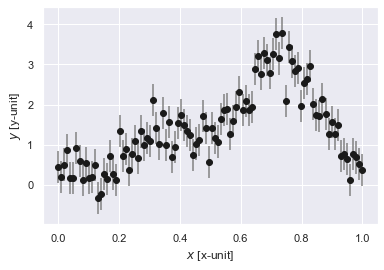

In [15]:
plt.errorbar(xk,Dk,yerr=sk,fmt='ok',ecolor='gray')
plt.xlabel('$x$ [x-unit]')
plt.ylabel('$y$ [y-unit]');

## Parameter estimation with your favorite MCMC sampler

In [16]:
#

## PyMultinest

In [21]:
import pymultinest

In [22]:
# number of lines
M=2
# number of dimensions our problem has
n_params = 2*M + 1

In [29]:
def prior(cube, ndim, nparams):
    '''Prior should transform the unit cube into the parameter cube. 
    We have a uniform prior [0,1] in all dimensions.'''
    pass

In [30]:
def loglike(cube, ndim, nparams):
    '''Log likelihood in PyMultinest format. Uses the (hyper)cube object from the prior.'''
    background  = cube[-1]
    amplitudes=[cube[i] for i in np.arange(0, ndim-1,2)]
    positions=[cube[i] for i in np.arange(1, ndim-1,2)]
    ymodel = G(data[0],amplitudes,positions) + background 
    loglikelihood = (-0.5 * ((ymodel - data[1]) / sigma_exp)**2).sum()
    return loglikelihood

In [25]:
# run MultiNest
datafile='pm_out'
base = f"{datafile}_{M}"
pymultinest.run(loglike, prior, n_params, outputfiles_basename=base, resume = False, \
                verbose = True, sampling_efficiency=0.8)

In [26]:
# Run the PyMultinest analyzer.
a = pymultinest.Analyzer(outputfiles_basename=base, n_params = n_params)
# get the best fit (highest likelihood) point
bestfit_params = a.get_best_fit()

  analysing data from pm_out_2.txt


In [28]:
a_lnZ = a.get_stats()['global evidence']
print('************************')
print('MAIN RESULT: Evidence Z ')
print('************************')
print(f'  log Z for model with {M} lines = {a_lnZ / np.log(10):.1f}')

************************
MAIN RESULT: Evidence Z 
************************
  log Z for model with 2 lines = -24.3
